In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install torchsummary

### Model

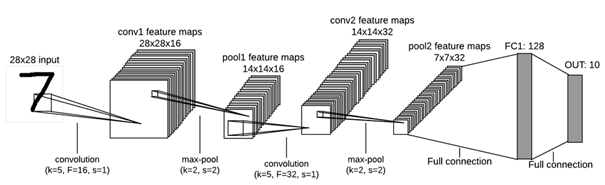

In [5]:
from torchsummary import summary

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.feature_maps = []

    def forward(self, x):
        x = F.relu(self.conv1(x))
        self.feature_maps.append(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        self.feature_maps.append(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def custom_init_weights(model):
    # Custom weights for conv1
    with torch.no_grad():
        custom_kernel = torch.tensor([[[[1, 0, -1], [1, 0, -1], [1, 0, -1]]]], dtype=torch.float32)
        repeated_kernel = custom_kernel.repeat(model.conv1.out_channels, 1, 1, 1)
        model.conv1.weight.copy_(repeated_kernel)

        # Đảm bảo rằng các trọng số còn lại được khởi tạo ngẫu nhiên hoặc theo cách bạn muốn
        nn.init.kaiming_normal_(model.conv2.weight)
        nn.init.constant_(model.conv2.bias, 0.0)

# Khởi tạo mô hình
model = SimpleCNN()

# Tùy chỉnh kernel đầu vào
custom_init_weights(model)

# Kiểm tra kernel đầu vào
print(model.conv1.weight[1])

tensor([[[ 1.,  0., -1.],
         [ 1.,  0., -1.],
         [ 1.,  0., -1.]]], grad_fn=<SelectBackward0>)


In [7]:
summary(model, (1, 28, 28))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

### Map feature map

In [ ]:
def plot_feature_maps(feature_maps, num_columns=8):
    for idx, fmap in enumerate(feature_maps):
        fmap = fmap.detach().cpu().numpy()
        num_filters = fmap.shape[1]

        # Tính toán số hàng cần thiết
        num_rows = (num_filters + num_columns - 1) // num_columns

        fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))
        fig.suptitle(f'Layer {idx+1} Feature Maps')

        for i in range(num_filters):
            row = i // num_columns
            col = i % num_columns
            ax = axes[row, col]
            ax.imshow(fmap[0, i]) #, cmap='gray'
            ax.axis('off')

        # Ẩn các ô trống nếu có
        for i in range(num_filters, num_rows * num_columns):
            row = i // num_columns
            col = i % num_columns
            ax = axes[row, col]
            ax.axis('off')

        plt.show()


In [ ]:
from torchvision import datasets, transforms
from PIL import Image

def load_image(image_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Chuyển đổi thành ảnh xám nếu cần
        transforms.Resize((28, 28)),  # Resize ảnh về kích thước 28x28
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    image = Image.open(image_path)
    image = transform(image)
    return image


In [ ]:
print(model.fc1.weight.shape)

In [ ]:
# # Khởi tạo mô hình và tải trọng số đã huấn luyện (nếu có)
# model = SimpleCNN()

# Đọc ảnh từ file
image_path = '/content/drive/MyDrive/DeepLearning/Research/OnCK/input_image.png'  # Thay thế bằng đường dẫn tới ảnh của bạn
image = load_image(image_path)

# Xóa feature maps cũ trước khi forward
model.feature_maps = []

# Forward qua mô hình
output = model(image.unsqueeze(0))

# Hiển thị các feature maps
plot_feature_maps(model.feature_maps)

### Huấn luyện

In [ ]:
def custom_mse_loss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

In [ ]:
class SimpleSGDOptimizer:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


In [ ]:
class AdamOptimizer:
  def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999):
    self.params = list(params)
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2

    self.iter = 0
    self.m = [0] * len(self.params)
    self.v = [0] * len(self.params)

  def step(self):
    self.iter += 1

    for i, param in enumerate(self.params):
      if param.grad is not None:
        self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
        self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad ** 2

        m_hat = self.m[i] / (1 - self.beta1 ** self.iter)
        v_hat = self.v[i] / (1 - self.beta2 ** self.iter)

        param.data -= self.lr * m_hat / (v_hat**0.5 + 1e-7)

  def zero_grad(self):
    for param in self.params:
      if param.grad is not None:
        param.grad.zero_()

In [ ]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Chuẩn bị dữ liệu MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Khởi tạo mô hình, hàm loss và optimizer
# model = SimpleCNN()
# optimizer = SimpleSGDOptimizer(model.parameters(), lr=0.01)
optimizer = AdamOptimizer(model.parameters())

# Huấn luyện mô hình
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        model.feature_maps = []
        optimizer.zero_grad()
        output = model(data)

        # Chuyển đổi target thành one-hot vector
        target_one_hot = torch.zeros(output.size()).scatter_(1, target.view(-1, 1), 1)

        loss = custom_mse_loss(output, target_one_hot)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item()}')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True).squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    accuracy = accuracy_score(all_targets, all_preds)

    return precision, recall, f1, accuracy

# Đánh giá mô hình sau mỗi epoch
precision, recall, f1, accuracy = evaluate(model, train_loader)
print(f'Epoch {epoch+1}/{num_epochs}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
def show_image_with_prediction(model, data_loader, index=0):
    model.eval()
    with torch.no_grad():
        data, target = next(iter(data_loader))
        image = data[index]
        true_label = target[index].item()

        output = model(image.unsqueeze(0))
        pred_label = output.argmax(dim=1, keepdim=True).item()

        image = image.squeeze().numpy()

        plt.imshow(image, cmap='gray')
        plt.title(f'True Label: {true_label}, Predicted Label: {pred_label}')
        if (true_label==pred_label):
            print('model dự đoán đúng')
        else:
            print('model dự đoán sai')
        plt.show()


In [ ]:
# Hiển thị ảnh và dự đoán
show_image_with_prediction(model, train_loader, index=0)

Hiển thị weight sau khi model hội tụ

In [ ]:
# lớp convolution 1
print(model.conv1.weight.shape)
print(model.conv1.weight[0])
# lớp convolution 2
print(model.conv2.weight.shape)
print(model.conv2.weight[0][0])
# lớp fully connected 1
print(model.fc1.weight.shape)
print(model.fc1.weight[0:10])
# lớp fully connected 2
print(model.fc2.weight.shape)
print(model.fc2.weight[0:10])